In [894]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек
import time
import random
import copy
from random import choice
from bs4 import BeautifulSoup
import pickle
import string # библиотека для работы со строками
import nltk   # Natural Language Toolkit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import pymorphy2
from tqdm import tqdm_notebook
from sklearn.metrics import *
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import warnings
import re
warnings.filterwarnings("ignore")
%matplotlib inline

In [901]:
pd.set_option('display.max_rows', None) # Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_columns', 150) # Сброс ограничений на число столбцов
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 150) # Сброс ограничений на количество символов в записи

In [10]:
!pip install fake_useragent

In [2]:
from fake_useragent import UserAgent

    Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами
    Цель:

    В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.

    Описание/Пошаговая инструкция выполнения домашнего задания:

    Часть 1. Парсинг.
        По аналогии с занятием, возьмите интересующий вас сайт,
            на котором можно пособирать какие-то данные (и при этом API не предоставляется).
        Идеальный датасет должен иметь текстовое описание некоторого объекта и
            некоторую целевую переменную, соответствующую этому объекту.
        Например:
            - Сайт новостей: текстовое описание - сама новость, целевая переменная - количество просмотров новости
                (можно поделить на число дней с момента даты публикации, чтобы получить “среднее число просмотров в день”).
            - Сайт с товарами/книгами/фильмами:
                текстовое описание товара/книги/фильма + средний рейтинг в качестве целевой переменной.
            - Блоги - тексты заметок + число просмотров.
            - И любые другие ваши идеи, которые подходят под такой формат.
        Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.
        Не забывайте, что парсинг - это ответственное мероприятие,
            поэтому не бомбардируйте несчастные сайты слишком частыми запросами
            (можно ограничить число запросов в секунду при помощи time.sleep(0.3), вставленного в теле цикла)

	Часть 2. NLP.

    Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования.
    Примените tf-idf преобразование для текстового описания.
	Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова,
		которые встречаются слишком редко или слишком часто (параметры min/max_df),
		не забудьте убрать l2 регуляризацию, которая по умолчанию включена.

    Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день),
		то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.

    Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик.
    Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.

	P.S. Если с парсингом не задалось или данных собралось слишком мало - не отчаивайтесь,
		главное, что ваш парсер собрал хоть что-то! А для второй части задания можно скачать данные по отзывам на фильмы с сайта IMDB
		(https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews),
		в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

#  <center> 「 Часть 1. Парсинг. 」  </center>

In [ ]:
''' краулером собираем ссылки на фильме, переходя по страницам стиска фильмов, и кладём все собранные ссылки в словарь '''

lin_7672 = dict() #сюда складысаем данные в формате "название фильма": "ссылка на страницу с подробными данными и коментариями"
for i in range(0,7672,25):
    url = f'http://www.world-art.ru/cinema/list.php?limit_1={i}&public_type=1&status=3&sort=1'
    ua = UserAgent()
    fake_ua = {'user-agent': ua.random}
    response = requests.get(url=url, headers=fake_ua)
    response.encoding = 'windows-1251'
    soup = BeautifulSoup(response.text, 'lxml')
    links = soup.find_all('a', class_='h3')
    for link in links:
        lin_7672[link.text] = ('http://www.world-art.ru/cinema/' + link['href'])
    sleep_time = random.uniform(5, 16) # задаём переыв дабы не нагружать сайт
    time.sleep(sleep_time)

In [ ]:
film_chart_7672 = copy.deepcopy(lin_7672) # на всякий случай копируем словарь и далее будем работать с копией

In [ ]:
''' make Dataframe from dict '''

film_chart_7672_df = pd.DataFrame.from_dict(film_chart_7672, orient='index', columns=['Links'])
film_chart_7672_df.reset_index(inplace=True)
film_chart_7672_df.rename(columns={'index':'title'}, inplace=True)

In [ ]:
''' Add columns to dataset '''

film_chart_7672_df = film_chart_7672_df.assign(Average_score = 0)
film_chart_7672_df = film_chart_7672_df.assign(number_of_comments = 0)
film_chart_7672_df = film_chart_7672_df.assign(Feedback = '')

In [ ]:
# film_chart_7672_df.to_csv('film_chart_7672_df_zeros.csv', index=False) # save dataset

In [ ]:
'''  Парсером проходимся по ссылкам и дополняем иформацию в датасете '''

ua = UserAgent()
fake_ua = {'user-agent': ua.random}

for link in film_chart_7672_df['Links'].to_list():

    url = link
    response = requests.get(url=url, headers=fake_ua)
    response.encoding = 'windows-1251'
    soup = BeautifulSoup(response.text, 'lxml')

    p_tags = soup.findAll('p', class_= 'review')
    td_tags = soup.findAll('td', class_= 'review')

    td_tag_result = []
    for td_tag in td_tags:
        text = td_tag.text
        td_tag_result.append(text)

    p_tag_result = list()
    for p_tag in p_tags:
        text = p_tag.text
        p_tag_result.append(text)

    x = p_tag_result.index('\n1. Старайтесь писать развёрнутые отзывы.\n2. Отзыв не может быть ответом другому пользователю или обсуждением другого отзыва.\n3. Чтобы общаться между собой, используйте ссылку «ответить».\n')

    film_chart_7672_df.loc[film_chart_7672_df['Links'] == link, 'Average_score'] = td_tag_result[td_tag_result.index('Средний балл')+1][:3]
    film_chart_7672_df.loc[film_chart_7672_df['Links'] == link, 'number_of_comments'] = len(p_tag_result[1::])-1
    film_chart_7672_df.loc[film_chart_7672_df['Links'] == link, 'Feedback'] = '*FLCL*'.join(p_tag_result[x+1:])

    sleep_time = random.uniform(1, 5)
    time.sleep(sleep_time)

# Wall time: 4h 7min 5s #film_chart_df_4191
# Wall time: 7h 24min 1s #film_chart_7672_df

In [ ]:
''' отсеиваем фильмы, у которых нет комментариев. '''
mask = film_chart_7672_df['Feedback'] == ''
film_chart_7672_df = film_chart_7672_df.drop(film_chart_7672_df[mask].index, axis=0)

In [ ]:
# film_chart_7672_df.to_csv('film_chart_7672_df_with_comments_no_blank.csv', index=False) # сохраняем получившийся датасет с данными

#  <center> 「 Часть 2. NLP. 」  </center>

# Data Preprocessing

In [110]:
film_chart_7672_df_with_comments_no_blank = pd.read_csv('film_chart_7672_df_with_comments_no_blank.csv')

In [878]:
film_chart_7672_df_with_comments_no_blank

<AxesSubplot:>

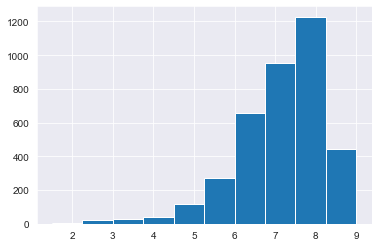

In [885]:
film_chart_7672_df_with_comments_no_blank['Average_score'].hist() # посмотрим, как распределены оценки

In [9]:
# film_chart_df_with_comments_no_blank_good = film_chart_df_with_comments_no_blank.query('Average_score > 7') # выборка хороших фильмов

In [11]:
# film_chart_df_with_comments_no_blank_bad = film_chart_df_with_comments_no_blank.query('Average_score <= 7') # выборка плохих фильмов

In [648]:
film_chart_7672_df_with_comments_no_blank['sentiment'] = film_chart_7672_df_with_comments_no_blank['Average_score'].apply(lambda x:  1 if x > 7.45 else 0)

In [671]:
film_chart_7672_df_with_comments_no_blank['number_of_comments'].sum()

12780

In [ ]:
"""
Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова,
	которые встречаются слишком редко или слишком часто (параметры min/max_df),
	не забудьте убрать l2 регуляризацию, которая по умолчанию включена.
"""

In [120]:
''' загружаем список стоп-слов для русского '''
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rost\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты']

In [327]:
# инициализируем лемматизатор
morph = pymorphy2.MorphAnalyzer()

In [206]:
''' Инициализируем `WordPunctTokenizer`, с помощью которого затем разобьем текст на слова. '''
word_tokenizer = nltk.WordPunctTokenizer()

In [746]:
''' Функция для приведения данных к нижнему регистру, очистки данных от знаков препинаний, стоп-слов, а так же токенизации '''
dates = [str(x) for x in np.arange(1900, 2023)]


def process_data(data):
    texts = []

    # поочередно проходим по всем новостям в списке
    for index in tqdm_notebook(range(data.shape[0])):
        text_raw = data['Feedback'][index]#.replace('*FLCL*', '')
        text_formated = re.sub(r'[\d«»()\[\]<>…*–?"!—\.]+', '', text_raw) # убираем то, что не было в string.punctuation
        text_lower = text_formated.lower() # приводим все слова к нижнему регистру
        tokens_loc = word_tokenizer.tokenize(text_lower) # разбиваем текст на слова []

        # удаляем пунктуацию и стоп-слова
        token = [word for word in tokens_loc if ( word not in stop_words and word not in dates )] #word not in string.punctuation and  and word not in words_to_drop

        texts.append(' '.join(token)) # добавляем в предобработанный список

    return texts

In [762]:
y = film_chart_7672_df_with_comments_no_blank['sentiment'].to_list()

In [747]:
texts = process_data(film_chart_7672_df_with_comments_no_blank.loc[:,:])

  0%|          | 0/3773 [00:00<?, ?it/s]

In [706]:
texts_pruned = process_data(film_chart_7672_df_with_comments_no_blank.loc[:,:])

  0%|          | 0/3773 [00:00<?, ?it/s]

In [748]:
# применяем лемматизацию ко всем текстам
text_lemmatized = []
for i in tqdm_notebook(range(len(texts))): # tqdm_notebook создает шкалу прогресса :)
    text_lemm = [morph.parse(x)[0].normal_form for x in texts[i].split()] # применяем лемматизацию для каждого слова в тексте
    text_lemmatized.append(' '.join(text_lemm))

  0%|          | 0/3773 [00:00<?, ?it/s]

In [707]:
# применяем лемматизацию ко всем текстам
text_lemmatized_v2 = []
for i in tqdm_notebook(range(len(texts_pruned))): # tqdm_notebook создает шкалу прогресса :)
    text_lemm = [morph.parse(x)[0].normal_form for x in texts_pruned[i].split()] # применяем лемматизацию для каждого слова в тексте
    text_lemmatized_v2.append(' '.join(text_lemm))

  0%|          | 0/3773 [00:00<?, ?it/s]

In [749]:
with open('text_lemmatized_world_art_all_movie_all_words.pkl', 'wb') as file:
    pickle.dump(text_lemmatized, file)

#  <center> 「 Обучение модели Random-Forest Classifier 」  </center>

In [651]:
''' Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования. '''
train_texts, test_texts, train_y, test_y = train_test_split(text_lemmatized, y, test_size=0.3, random_state=42, stratify = y)

In [810]:
train_texts, test_texts, train_y, test_y = train_test_split(text_lemmatized_v2, y, test_size=0.3, random_state=42, stratify = y) # тут удалены самые частые и самые редкие слова

In [764]:
''' Инициализируем векторайзер '''

vectorizer = CountVectorizer(max_features = 1000)
vectorizer.fit(train_texts)

CountVectorizer(max_features=1000)

In [765]:
''' Топ-20 слов '''
vectorizer.get_feature_names()[:20]

['the',
 'абсолютно',
 'аватар',
 'автор',
 'агент',
 'актриса',
 'актёр',
 'актёрский',
 'америка',
 'американец',
 'американский',
 'английский',
 'анимация',
 'аниме',
 'армия',
 'атмосфера',
 'аудитория',
 'балл',
 'банальный',
 'бежать']

In [766]:
''' Обучаем vectorizer на train-данных и сразу преобразем их в вектора с помощью метода fit_transform '''
train_X = vectorizer.fit_transform(train_texts)
train_X.todense()[:2]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [767]:
test_X  = vectorizer.transform(test_texts)

In [713]:
"""
Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день),
		то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.
"""

'\nЕсли в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день),\n\t\tто воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.\n'

In [714]:
param_grid = {
    'n_estimators': [500, 800],
    'max_depth': [10, 15],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [2, 4, 8],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_

In [715]:
best_params

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 800}

In [716]:
# инициализируем модель
clf = RandomForestClassifier(n_estimators = 800, max_depth = 15, min_samples_split = 8, min_samples_leaf = 2)

# обучаем ее на тренировочных данных
clf = clf.fit(train_X, train_y)

# делаем предсказание для тестовых данных
pred = clf.predict(test_X)

In [717]:
print('Предсказанные метки: ', pred[0:20], ".....")
print('Истинные метки: ', list(test_y)[0:20], ".....")

Предсказанные метки:  [1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0] .....
Истинные метки:  [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0] .....


In [718]:
print(accuracy_score(test_y, pred)) #0.6342756183745583

0.666077738515901


# ''' lets try xgboost '''

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15],
    'min_child_weight': [1, 2, 4],
    'learning_rate': [0.1, 0.01, 0.3],
    'gamma': [0, 0.1, 0.3, 0.5, 0.7]
}

xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=5)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_

In [622]:
best_params

{'gamma': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 4,
 'n_estimators': 400}

In [629]:
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0,
                              n_estimators=700,
                              gamma=0.7,
                              learning_rate=0.1,
                              max_depth=10,
                              min_child_weight=4)

xgb_model.fit(train_X, train_y)

pred = xgb_model.predict(test_X)

In [630]:
print('Предсказанные метки: ', pred[0:20], ".....")
print('Истинные метки: ', list(test_y)[0:20], ".....")

Предсказанные метки:  [0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0] .....
Истинные метки:  [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0] .....


In [631]:
print(accuracy_score(test_y, pred)) #0.6342756183745583

0.5468197879858657


Результат хуже, чем у леса

# """Примените tf-idf преобразование для текстового описания."""

    Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день),
		то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.

    Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик.

в начале, попробую классифицировать с помощью леса из лекции и сравню с TfidfVectorizer

In [722]:
param_grid = {
    'n_estimators': [300, 500, 800],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [2, 4, 8],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_

In [723]:
best_params

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 500}

In [758]:
#import алгоритма из библиотеки
from sklearn.ensemble import RandomForestClassifier

# инициализируем модель
clf = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_split = 4, min_samples_leaf = 2)

# обучаем ее на тренировочных данных
clf = clf.fit(train_X, train_y)

# делаем предсказание для тестовых данных
pred = clf.predict(test_X)

In [759]:
print(accuracy_score(test_y, pred)) #0.6448763250883393

0.6439929328621908


# TF-IDF Vectorizer

In [863]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 9450, min_df=4, max_df=0.9, ngram_range=(1, 2), use_idf=True, norm='l2')),
    ('clf', LogisticRegression(penalty='none', solver='lbfgs'))
])

test_X = [str(doc) for doc in train_texts]
pipeline.fit(test_X, train_y)

test_X = [str(doc) for doc in train_texts]
predictions = pipeline.predict(test_texts)

In [864]:
print(accuracy_score(test_y, predictions))

0.681095406360424


In [ ]:
''' результат лучше, чем у леса '''

# теперь добавлю датасет, созданный с помощью библиотеки Dostoevsky Sentiment analysis, и посмотрим. как изменятся результаты если в качестве целевой переменной будет оценка достоевкого.

In [ ]:
'''
тут будет код, который мне удалось запустить исключительно в google collab:
в нем я подгрузил обработаные данные и с помощью достоевского произвёл их оценку и внёс результат в датасет
'''
'''
!pip install  dostoevsky
!python -m dostoevsky download fasttext-social-network-model
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

with open('text_lemmatized_world_art_all_movie_all_words.pkl', 'rb') as file:
    text_lemmatized_all_words = pickle.load(file)



dostoevskiy_df = pd.DataFrame()
dostoevskiy_df = pd.DataFrame(text_lemmatized_all_words, columns=['lemmatized_comments'])
dostoevskiy_df = dostoevskiy_df.assign(model_k_1 = '-')
dostoevskiy_df = dostoevskiy_df.assign(model_k_3 = '-')
dostoevskiy_df = dostoevskiy_df.assign(dostoevskiy_sentiment = 0)

'''-----------------------'''
for i in range(len(text_lemmatized_all_words)):
  messages = [''.join(text_lemmatized_all_words[i].split('flcl'))] # это список с каментами
  results = model.predict(messages, k=3)
  # print(messages)

  for message, sentiment in zip(messages, results):
    print(message, '\n', sentiment)
    # dostoevskiy_df.at[i, 'model_k_1'] = ''.join([k for k in sentiment.keys()]) # k=1
    dostoevskiy_df.at[i, 'model_k_3'] = {k:round(v, 3) for k,v in sentiment.items()}

dostoevskiy_df.to_csv('dostoevskiy_df.csv', index=False)
'''

In [ ]:
dostoevskiy_df = pd.read_csv('dostoevskiy_df.csv')

In [904]:
dostoevskiy_df['dostoevskiy_sentiment'] = dostoevskiy_df['model_k_1'].apply(lambda x:  1 if x == 'positive' else 0 if x == 'neutral' else -1 )

можно заметить, что оценка коментария сильно расходится с рейтингом фильма, что с одной стороны странно, ведь хороший фильм должен иметь скорее хорошие отзывы.

In [905]:
dostoevskiy_df

lemmatized_comments  \
0     фильм нужно видеть весь он задевать наверное история , история , история , история человек , различный история человек , попасть тюрьма , какой - ...   
1     краткий содержание пересказать лишь один линия многопластовый фильм , причём , взгляд , самый ценный лично впечатлить сфера сказочность , всё оста...   
2     сколько видеть фильм , , скорее , ибо год каждый смотреть фильм , казаться , идти бесконечно долго короткий человеческий жизнь , описанный сторона...   
3     наёмный убийца , который постоянно пить молоко ухаживать фикус это невероятно милоflclкак крутить , , работать люк бессон становиться гениальный ,...   
4     фильм , натолкнуть мысль , последний надежда который умирать два чудак предстоять умереть умереть шуточно настоящий понимать , тот цель ради котор...   
5     самый разнообразный живность , полностью наполнить саванна , замереть подножие гора ожидание великий момент , представить будущее король маленький...   
6     замечательный очень смешной комедия российский комедийный эталон великолепный сюжет игра яркий талантливейшихроссийский актёр делать фильм действи...   
7     этот фильм смело ставить балл комментарий невозможно описать послевкусие просмотр дать картина скептически отнестись фильм начало просмотр , очень...   
8     любимый фильм это всё сказать узнать фильм снятой роман чак паланик , сразу взахлёб прочитать книгипочему - многий фильм отталкивать первый минута...   
9     фильм смотреть наверно , переставать удивлять мастерство актёр смеяться переставать , таки это очень тяжело заставлять человек смеяться спустя сто...   
10    итак , вы руководство , экранизировать книгува смочь очень удачно убить атмосфера дух книга : вложить фильм очень денега пытаться следоватеь весь ...   
11    прекрасный фильм режиссёр , быв война , очень чётко суметь описать военный быт лётчик замечательный постановка , чудесный фильмflclпрекрасный филь...   
12    властелин кольцо очень интересный фильм начало рассказ книга толкина хоббит рассказать , бильбо встретиться голлум , он попасть кольцо поход драко...   
13    сказать честно , фильм смотреть аниме , признаться , поразить мастерство красота фильм снимать акира куросава шляпуflclтак получиться , глянуть фи...   
14    наверно именно этот часть заставлять понять насколько снаять другой часть дать часть просто прекрасно сняато очень сильно многое совпадать книгойf...   
15    фильм супер , хочеться смотреть снова сноваклассный игра актёр , красивый декорация , крутой спецэффект фильмасоветовать посмотреть всемflclфильм ...   
16    несомненно , великий фильм история кино великолепный актёрский работа вкупе мощный сценарий гениальный постановка позволять вновь вновь наслаждать...   
17    фильм самый любимый = время ставить разгрузиться просто посмеиться прабабушка кстати звукорежисерflclклассик советский кино оставаться шедевр прот...   
18    видеть купить билет решить пересмотреть впечатление умереть сразу , который шаткий , клоун моноциклео мой итоговый впечатление узнать время , это ...   
19    детство один мой любимый фильм - впервые увидеть видеосалон какой - кошмарный качествеоценка - - память прошлый : flclсамый настоящий шедевр остал...   
20    мастерский фильм мощный диалог , убойный юмор , наигранность затягиваться перестрелка одназначный шедеврflclный первый очередь число находка необх...   
21    ип ман признанный мастер кунг - фу , жить фуошана , город , славный свой школа боевой искусство ип ман практиковать вино чун хотя являться сильный...   
22    бесподобный , просто бесподобный новый произведение один хороший европейский режиссёр работать коммерческий анимация этнос благодатный тема кино ,...   
23    хороший терминатор , порядок превосходить первый фильм , третийвеликолепный боевик , легенда свой временина смотреть серьёзность жанр фильм , смот...   
24    смотреть сериал два вариант : номальный перевод гоблин принцип разници , гоблин перевод идти дословно мат переводить фильм стиль гай риччи казатьс...   
25

In [906]:
y_new = dostoevskiy_df['dostoevskiy_sentiment'].to_list()

In [908]:
train_texts, test_texts, train_y_new, test_y_new = train_test_split(text_lemmatized, y_new, test_size=0.3, random_state=42, stratify = y_new)

In [920]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 3500, min_df=4, max_df=0.9, ngram_range=(1, 2), use_idf=True, norm='l2')),
    ('clf', LogisticRegression(penalty='none', solver='lbfgs'))
])

test_X = [str(doc) for doc in train_texts]
pipeline.fit(test_X, train_y_new)

test_X = [str(doc) for doc in train_texts]
predictions = pipeline.predict(test_texts)

In [921]:
print(accuracy_score(test_y_new, predictions)) #0.7632508833922261

0.7632508833922261


результат стал лучше!

In [928]:
vectorizer = CountVectorizer(max_features = 1000)
vectorizer.fit(train_texts)

CountVectorizer(max_features=1000)

In [924]:
train_X = vectorizer.fit_transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [929]:
"""прогоним обучение на лесе"""
param_grid = {
    'n_estimators': [300, 500, 800],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [2, 4, 8],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(train_X, train_y_new)

best_params = grid_search.best_params_

In [930]:
best_params

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [931]:
#import алгоритма из библиотеки
from sklearn.ensemble import RandomForestClassifier

# инициализируем модель
clf = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_leaf = 2, min_samples_split = 2)

# обучаем ее на тренировочных данных
clf = clf.fit(train_X, train_y_new)

# делаем предсказание для тестовых данных
pred = clf.predict(test_X)

In [932]:
print(accuracy_score(test_y_new, pred))

0.666077738515901


тут результат улучшился незначительно
В целом с целевой переменной размеченной с помощью достоевского результат получается лучше

# Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.

In [268]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rost\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [266]:
from nltk.probability import FreqDist

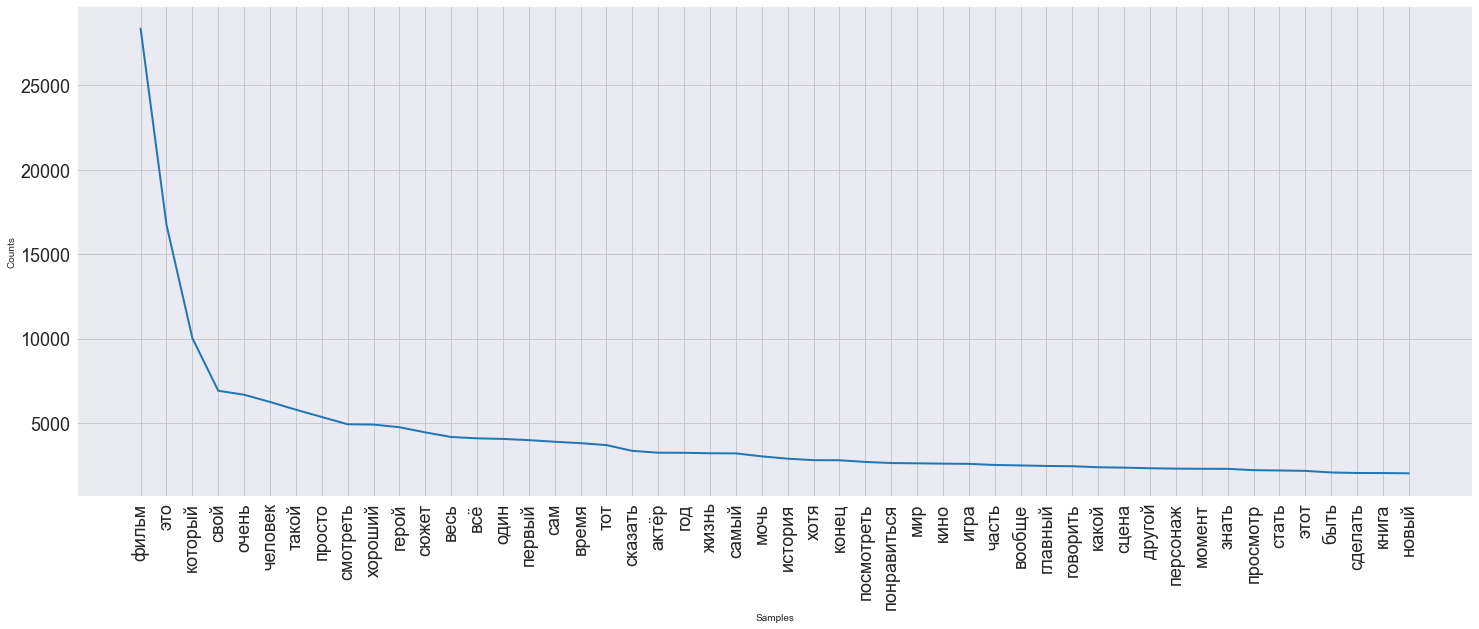

In [635]:
text = ' '.join(text_lemmatized)
text = text.translate(str.maketrans("", "", string.punctuation))
tokens = nltk.word_tokenize(text)
fd = FreqDist(tokens)
plt.figure(figsize=(25,9))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fd.plot(50, cumulative=False)

plt.show()

# посмотрим, повлияет ли на результат, если отбросить слова, которые встречаются слишком редко или слишком часто

In [683]:
first_9_words = fd.most_common(9)

In [687]:
most_common_words = [ i[0] for i in first_9_words]

In [672]:
sorted_fd = sorted(fd.items(), key=lambda x: x[1])

In [677]:
least_50_words = sorted_fd[:50]

In [689]:
most_rare_words = [ i[0] for i in least_50_words]

In [691]:
words_to_drop = most_rare_words + most_common_words

In [701]:
text_lemmatized_pruned = []
for i in range(len(text_lemmatized)):
    for word in text_lemmatized[i].split():
        if word not in words_to_drop:
            text_lemmatized_pruned.append(word)


In [ ]:
'''результат стал лучше!'''

# ''' Lets try some interesting things!'''

In [221]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

In [933]:
import matplotlib.pyplot as plt

text = ' '.join(text_lemmatized_v2) # 9_694_692
wordcloud = WordCloud(
    width = 4800, height = 2400,
    background_color ='white',
    stopwords = set(stop_words),
    min_font_size = 12).generate(text)

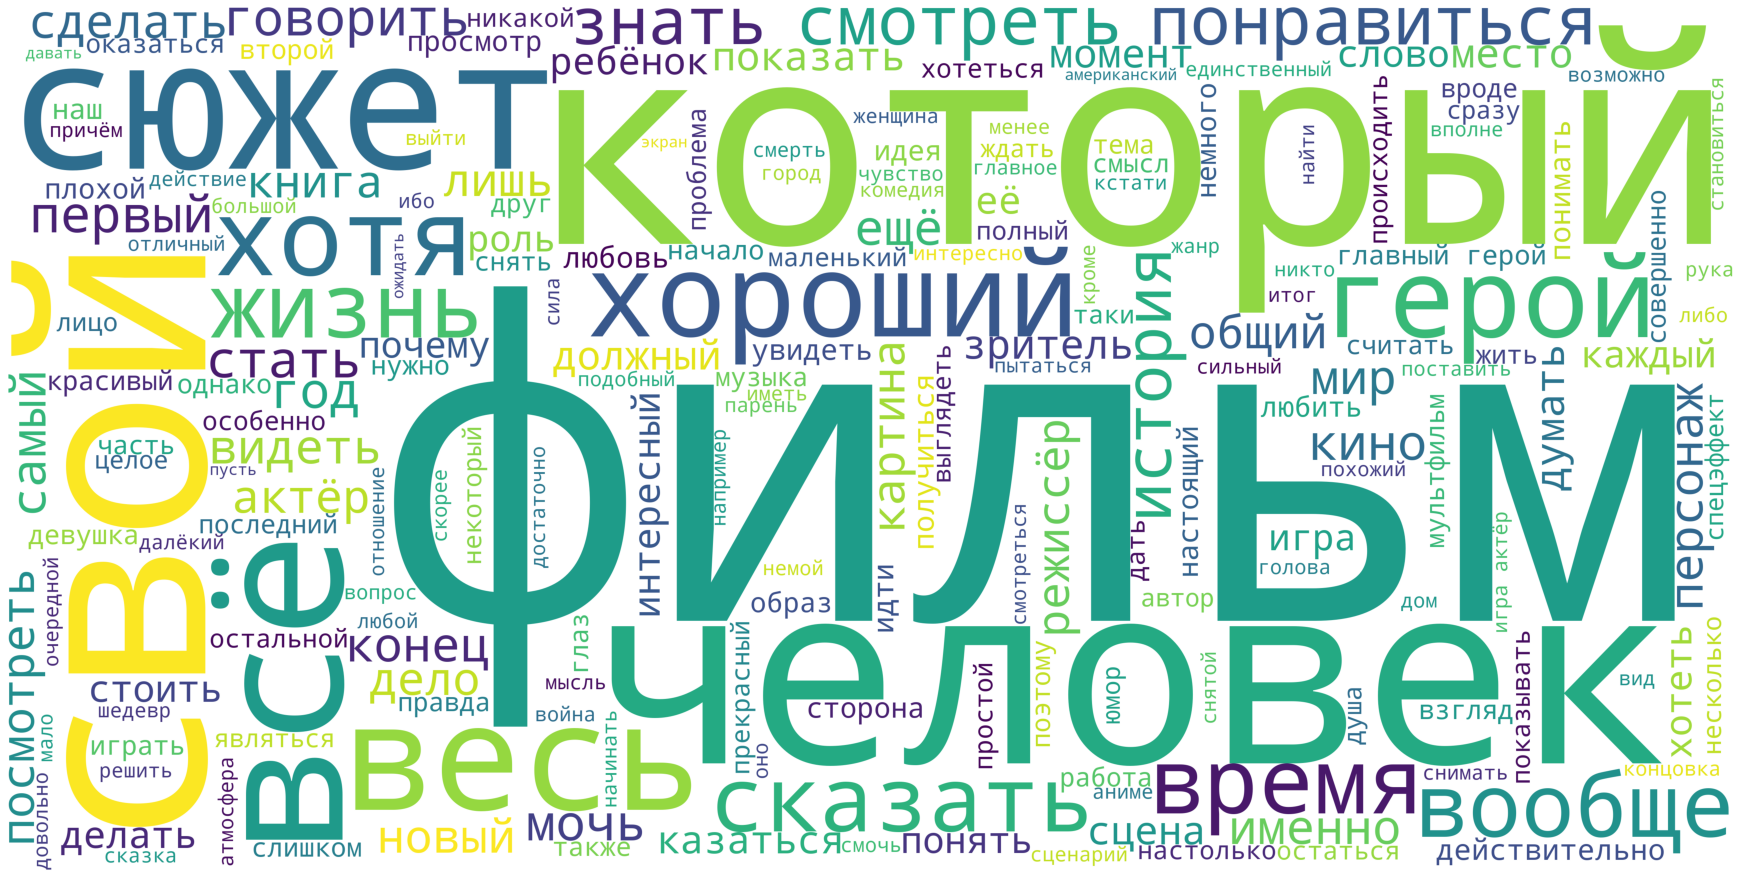

In [934]:
plt.figure(figsize = (24, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# Выводы

In [937]:
united_df = pd.concat([film_chart_7672_df_with_comments_no_blank, dostoevskiy_df], axis=1) # Объединим датасеты, чтобы можно было наблюдать результат

In [938]:
united_dfBeautifulSoup

title  \
0                                                         Побег из Шоушенка   
1                                                              Зелёная миля   
2                                                              Форрест Гамп   
3                                                                      Леон   
4                                                      Достучаться до небес   
5                                                                Король Лев   
6                                          Иван Васильевич меняет профессию   
7                                                                       1+1   
8                                                           Бойцовский клуб   
9                                  Операция «Ы» и другие приключения Шурика   
10                                      Властелин колец: Возвращение Короля   
11                                                В бой идут одни «старики»   
12                                         Властелин колец: Братство Кольца   
13                                                            Семь самураев   
14                                            Властелин колец: Две крепости   
15                                                                Гладиатор   
16                                                            Крёстный отец   
17                                                       Бриллиантовая рука   
18                                                Хатико. Самый верный друг   
19                                                          Назад в будущее   
20                                                       Криминальное чтиво   
21                                                                   Ип Ман   
22                                                               Песнь моря   
23                                                Терминатор 2: Судный день   
24                                                              Большой куш   
25                                                    Как приручить дракона   
26                                                                  Матрица   
27                                                           Собачье сердце   
28                                                       Легенда о пианисте   
29                                                          Список Шиндлера   
30                                                           Храброе сердце   
31                                                   В джазе только девушки   
32                                                                   ВАЛЛ-И   
33                                                              Игры разума   
34                                                   Пираты Карибского моря   
35                                               Карты, деньги & два ствола   
36                                                    Укрощение строптивого   
37                                             Пролетая над гнездом кукушки   
38                                                    А зори здесь тихие...   
39                                                        Невидимая сторона   
40                                                          Подводная лодка   
41                                                            Запах женщины   
42                                                                  Ушедшие   
43                                                               Август Раш   
44                                                                    Клаус   
45                                                            Человек дождя   
46                                               Назад в будущее, часть III   
47                                                           Эффект бабочки   
48                                                 Американская История Икс   
49                                                Назад в будущее, часть II   
50                                       

В начале, я хочу высказаться про парсинг - теперь стало трудно без Seleniuma, т.к. большинствоо современных сайтов имеют крайне сложную архитектуру. По этой причине я выбрал world-art - тут получилось обойтись библиотеками requests и BeautifulSoup.
По интерпретации текста: отзывы на фильмы - это крайне неоднозначная метрика, что я имею в виду: у самых лучших фильмов могут быть как почитатели, так и хэйтеры, что делает общую оценку всех комментариев к конкретному фильму средней (neutral) от чего я получал плохие результаты в начале, до использования библиотеки достоевский. Использование же библиотеки достоевский ещё сильнее подтвердило, что отзывы - это субъективная вещь, так как разбирая отдельные отзывы и части отзывов получались противоречивые результаты, как пример хорошая оценка от достоевского для фильма с самым плохим рейтингом. Возможно, что модели необходимо добучение.
В объединённом датасете можно увидеть, насколько неоднозначные комментарии у фильмов - колонка 'dostoevskiy_sentiment' содержит оценку выданную на основании анализа всех комментариев к фильму. И видно, что оценки от модели идут в разрез с рейтингом фильма.
Всё в целом является следствием того, что люди очень разные. Полагаю, что схожие результаты будут и при анализе игр, товаров и услуг.
Эта тема так же усложняется тем, что русский язык очень сложен для интерпретации, а тем более комментарии, где зачастую нет соблюдения правил.